In [16]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 

def warn(*args, **kwargs):
    pass
warnings.warn = warn

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [5]:
# from csv file created using utils.collect_curves_tofiles()
# all_curves = pd.read_csv('./Data/flux_phase_200_1000_50.csv', header = None)
# all_times = pd.read_csv('./Data/time_phase_200_1000_50.csv', header = None)
# all_labels = pd.read_csv('./Data/labels_phase_200_1000_50.csv', header = None)
all_curves = pd.read_csv('./Data/flux_phase_1000_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### AdaBoostClassifier

In [21]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=100)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {'base_estimator__max_depth':[10,20],
              'base_estimator__min_samples_leaf':[5,7],
              'n_estimators':[60,70],
              'learning_rate':[0.01,0.01]}

grid = GridSearchCV(ab, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

grid.fit(X_train_interp, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mining/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:720: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
/Users/ashutoshgandhi/Data Mini

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise',
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=100),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [10, 20],
                         'base_estimator__min_samples_leaf': [5, 7],
                         'learning_rate': [0.01, 0.01],
                         'n_estimators': [60, 70]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [22]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 5, 'learning_rate': 0.01, 'n_estimators': 70}
Best estimator is: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_samples_leaf=5),
                   learning_rate=0.01, n_estimators=70, random_state=100)
Best Validation accuracy is: 0.74875


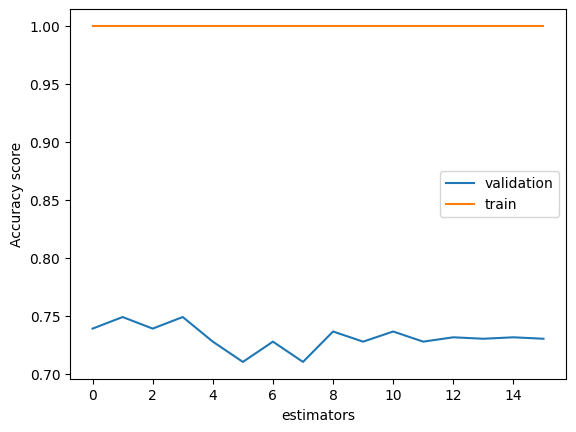

In [26]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [27]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.755


<Figure size 1500x600 with 0 Axes>

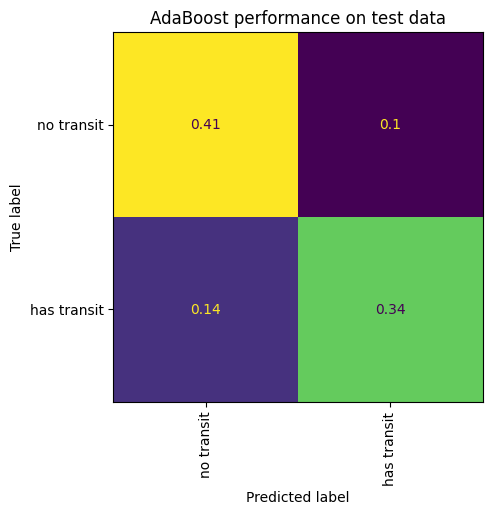

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       103
           1       0.77      0.70      0.74        97

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.75       200

Recall score is 0.7010309278350515


In [28]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('AdaBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

## GradientBoostingClassifier

In [41]:
gbc = GradientBoostingClassifier(random_state=100)

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # k-fold cross validation

param_grid = {
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5,7, 10],
    "max_depth":[5,10,20,30],
    "max_features":["log2","sqrt"],
    "n_estimators":[100, 125, 150]
}

grid = GridSearchCV(gbc, param_grid, refit = True, cv = folds, scoring='accuracy', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)

grid.fit(X_train_interp, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise',
             estimator=GradientBoostingClassifier(random_state=100), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [5, 10, 20, 30],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': [100, 125, 150]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [42]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation accuracy is: {grid.best_score_}")

Best hyperparameter is: {'learning_rate': 0.15, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
Best estimator is: GradientBoostingClassifier(learning_rate=0.15, max_depth=30,
                           max_features='sqrt', min_samples_leaf=5,
                           n_estimators=150, random_state=100)
Best Validation accuracy is: 0.78375


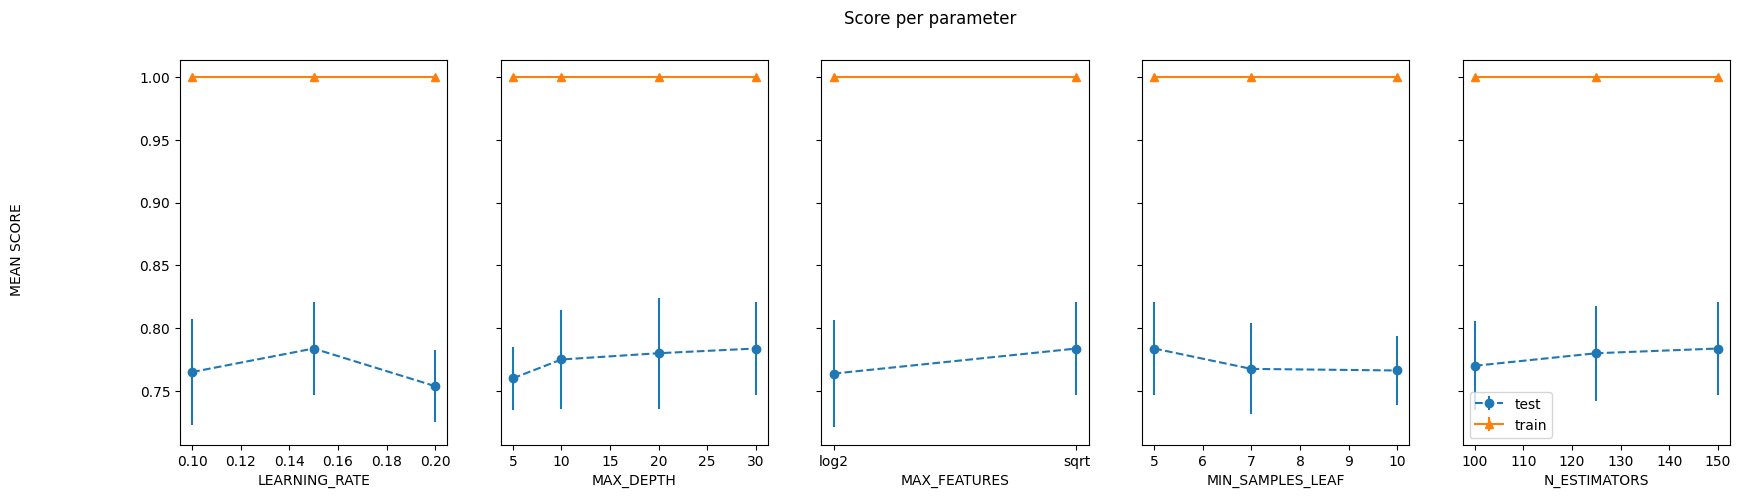

In [43]:
results = grid.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

## Getting indexes of values per hyper-parameter
masks=[]
masks_names= list(grid.best_params_.keys())
for p_k, p_v in grid.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params=grid.param_grid

## Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

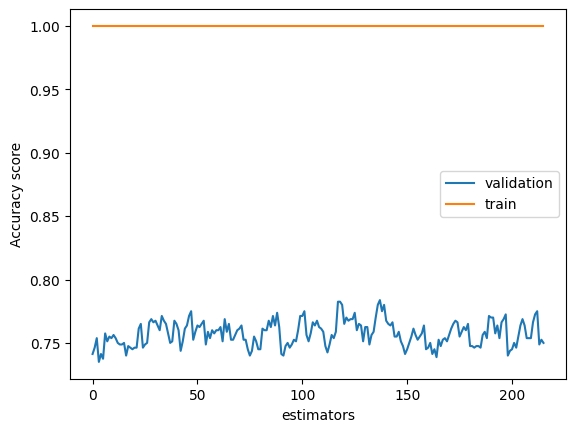

In [44]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.xlabel('estimators')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

### Results

In [45]:
svc_pred_test = grid.predict(X_test_interp)
svc_pred_train = grid.predict(X_train_interp)
print('train/validation accuracy:', np.round(accuracy_score(y_train , svc_pred_train),4))
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

train/validation accuracy: 1.0
test accuracy: 0.77


<Figure size 1500x600 with 0 Axes>

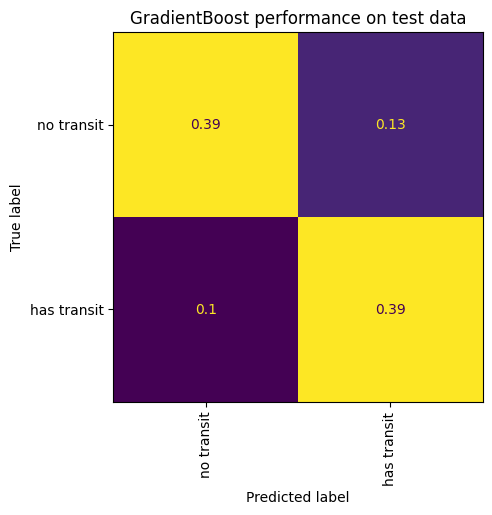

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       103
           1       0.75      0.79      0.77        97

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.77      0.77      0.77       200

Recall score is 0.7938144329896907


In [46]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('GradientBoost performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")